<h1> I. Beginning </h1>

In [1]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')
# ---

%matplotlib inline
import pandas as pd
pd.options.display.max_columns = 100
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import seaborn as sns
sns.set(color_codes=True)
import numpy as np
# import xgboost as xgb
# from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Performing grid search

pd.options.display.max_rows = 100

C:\Users\mszafraniec\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\mszafraniec\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# Feature Importance
from sklearn import datasets
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

## Import Data

In [3]:
train = pd.read_csv('./data/train.csv', sep = ",")
test = pd.read_csv('./data/test.csv', sep = ",")

In [4]:
IDtest = test['sample_id']
test.drop('sample_id',inplace=True,axis=1)

In [5]:
test.head()

,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age
0,50,1478104371,683078,82356,1,20021008,0,0,542,1,0,17698,2076,30
1,2744,1479317140,876497,99692,1,19851231,0,0,307,1,0,10525,26,28
2,2744,1479546361,876497,99692,1,19851231,0,0,307,1,0,8716,26,27
3,2744,1478457729,876500,99692,1,19851231,2,1,265,1,0,5443,26,30
4,2744,1480448560,876504,99692,1,19851231,2,1,356,1,0,7600,26,29


In [6]:
train.describe()

,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age,is_listened
count,7.558834e+06,7.558834e+06,7.558834e+06,7.558834e+06,7.558834e+06,7.558834e+06,7.558834e+06,7.558834e+06,7.558834e+06,7.558834e+06,7.558834e+06,7.558834e+06,7.558834e+06,7.558834e+06,7.558834e+06
mean,2.245030e+03,1.479011e+09,7.839624e+07,8.136169e+06,2.360018e+00,2.011388e+07,4.731900e-01,2.558086e-01,2.311527e+02,3.068742e-01,3.936884e-01,4.037300e+03,1.500740e+06,2.431278e+01,6.840330e-01
std,1.308979e+04,1.189935e+07,5.133633e+07,5.460090e+06,4.659856e+00,7.570138e+04,7.353008e-01,5.481663e-01,7.999463e+01,4.611968e-01,4.885672e-01,3.954754e+03,2.519546e+06,3.767797e+00,4.648999e-01
min,0.000000e+00,1.000000e+00,2.000580e+05,1.976000e+03,0.000000e+00,1.900010e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.800000e+01,0.000000e+00
25%,0.000000e+00,1.478460e+09,1.376614e+07,1.255566e+06,0.000000e+00,2.009123e+07,0.000000e+00,0.000000e+00,1.960000e+02,0.000000e+00,0.000000e+00,8.990000e+02,2.605000e+03,2.100000e+01,0.000000e+00
50%,3.000000e+00,1.479057e+09,9.380660e+07,9.525626e+06,1.000000e+00,2.014103e+07,0.000000e+00,0.000000e+00,2.220000e+02,0.000000e+00,0.000000e+00,2.738000e+03,1.941720e+05,2.500000e+01,1.000000e+00
75%,2.700000e+01,1.479742e+09,1.262592e+08,1.329221e+07,2.000000e+00,2.016061e+07,1.000000e+00,0.000000e+00,2.540000e+02,1.000000e+00,1.000000e+00,6.064000e+03,1.519461e+06,2.800000e+01,1.000000e+00
max,2.597310e+05,1.480636e+09,1.372601e+08,1.472086e+07,7.300000e+01,3.000010e+07,2.000000e+00,2.000000e+00,6.553500e+04,1.000000e+00,1.000000e+00,1.991700e+04,1.144741e+07,3.000000e+01,1.000000e+00


### Take out absurd data

In [7]:
train.drop(train.index[(train['media_duration'] <= 30)*(train['is_listened'] == 1)], axis = 0, inplace = True)
train.drop(train.index[train['release_date'] > 30000000], axis = 0, inplace = True)

In [8]:
import time
import datetime
conv_date = lambda x: time.mktime(datetime.datetime.strptime(str(x)[:6], '%Y%m').timetuple())
train['release_date'] = (1000000 + train['release_date']).apply(conv_date) - 100*365.25*24*3600 #on rajoute et enleve 100 ans pour gerer les problemes d'overflow
test['release_date'] = (1000000 + test['release_date']).apply(conv_date) - 100*365.25*24*3600

In [9]:
train.drop(train.index[train['ts_listen'] > time.time()], axis = 0, inplace = True)
train.drop(train.index[train['ts_listen'] < 1230764491], axis = 0, inplace = True)
train.drop(train.index[train['release_date'] > time.time()], axis = 0, inplace = True)
# train.drop(train.index[train['ts_listen'] < train['release_date']], axis = 0, inplace = True) 28827 valeurs dans le train, 32 dans le test, presques toutes avec genre_id == 0

In [10]:
# not so bad anyways... - and none in the test
# len(train[train['ts_listen'] < 1230764491]) (= 631)

### Combined contains the common columns to the test and train set, in order to apply the same transformations on all the data

In [11]:
target = train['is_listened']
train.drop('is_listened', axis = 1, inplace = True)
combined = train.append(test)
combined.reset_index(inplace=True)
combined.drop('index', axis = 1, inplace = True)
combined = combined.join(target)
train['is_listened'] = target

In [12]:
combined.head()

,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age,is_listened
0,25471,1480597215,222606,41774,12,1.088550e+09,1,0,223,0,0,9241,55164,29,0.0
1,25571,1480544735,250467,43941,0,1.141085e+09,2,1,171,0,0,16547,55830,30,1.0
2,16,1479563953,305197,48078,1,1.404083e+09,2,1,149,1,1,7665,2704,29,1.0
3,7,1480152098,900502,71521,0,9.702684e+08,0,0,240,0,1,1580,938,30,0.0
4,7,1478368974,542335,71718,0,1.201738e+09,0,0,150,0,1,1812,2939,24,1.0


In [13]:
# Took the data from "input.csv"

# How to process it?

# Genre_id, media_id, album_id, user_id, artist_id -> aggregate (e.g. count)
# Ts_listen, release_date: date under 2 different formats -> put to same format
# Context_type -> one-hot-encode
# Platform_name, platform_family -> one-hot encode? Aggregate?
# Media_duration -> this one seems simple, keep as is
# Listen_type -> probably keep as is, but not sure
# User_gender -> keep as is (sexism!)
# User_age -> keep as is

# Other ideas: compute mean length for an album, an artist, a genre, mean of is_listened for each user, each artist, etc using the date 
# Using the date, we can compute the number of songs he listened in a row

# I think the key here is correctly using the information about artist, etc...


<h1> II. Feature Preparation </h1>

In [14]:
def medianNan(s):
    global combined
    combined[s].fillna(np.median(combined[~np.isnan(combined[s])][s]), inplace=True)

### Filling NaN values with the median of the column

In [15]:
# for s in combined.columns[1:]:
#     print(s,type(combined[s][0]))
#     medianNan(s)

### Dealing with categoricals

In [16]:
categorical = ['platform_name', 'platform_family'] ## 'context_type' TOO BIG! (MemoryError)

In [17]:
def dummify(variable):
    global combined
    local_dummies = pd.get_dummies(combined[variable],prefix=variable)
    combined = pd.concat([combined,local_dummies],axis=1)
    combined.drop(variable,axis=1,inplace=True)

In [18]:
for s in categorical:
    dummify(s)

## DATA VISUALISATION

### Same user ID's in test and train

In [19]:
sorted(train['user_id'].unique()) == sorted(test['user_id'].unique())

True

### listen_type == 1 in test set (apart from one value)

In [20]:
sorted(test['listen_type'])[1]

1

<h1> III. Feature Engineering </h1>

## Genre_id, media_id, album_id, user_id, artist_id -> aggregate (e.g. count)

### Number of times an user has listened to a given song, artist etc?

In [21]:
def aggregation_functions(names, put_avrg = True):
    
    global combined
    global train
    
    name = '_'.join(names)
    
    if put_avrg:
        avrg = train.groupby(names)['is_listened'].mean()
        avrg.name = 'avrg_listened_' + name + '_temp'
        combined = combined.join(avrg, names, 'left', 'l')
        combined['avrg_listened_' + name + '_temp'].fillna(.5, inplace=True)
    
    count_ = train.groupby(names)[names[-1]].count()
    count_.name = 'count_' + name
    combined = combined.join(count_, names, 'left', 'l')
    
    if put_avrg: # Compute mean without this line: compute mean with ALL lines then substract this one, linear operation
        combined['avrg_listened_' + name] = ((combined['avrg_listened_' + name + '_temp']*combined['count_' + name] - train['is_listened'])/(combined['count_' + name] - 1))[:len(train)].append(combined[len(train):]['avrg_listened_' + name + '_temp']) # Soooo smart
        combined['avrg_listened_' + name] /= (combined['count_' + name] >= 5)
        combined.drop('avrg_listened_' + name + '_temp', axis = 1, inplace = True)
    
    combined['count_' + name].fillna(0, inplace=True)

In [22]:
aggregation_functions(['user_id'])
aggregation_functions(['user_id', 'listen_type'])
aggregation_functions(['user_id', 'artist_id'], False)
aggregation_functions(['user_id', 'artist_id', 'listen_type'], False)
aggregation_functions(['user_id', 'media_id'], False)
aggregation_functions(['user_id', 'media_id', 'listen_type'], False)
aggregation_functions(['user_id', 'genre_id'])
aggregation_functions(['user_id', 'genre_id', 'listen_type'])

combined.replace([np.inf, -np.inf], np.nan, inplace=True)
medianNan('avrg_listened_user_id')
combined['avrg_listened_user_id_listen_type'].fillna(combined['avrg_listened_user_id'], inplace=True)
combined['avrg_listened_user_id_genre_id'].fillna(combined['avrg_listened_user_id'], inplace=True)
combined['avrg_listened_user_id_genre_id_listen_type'].fillna(combined['avrg_listened_user_id_genre_id'], inplace=True)

In [23]:
np.sum(combined['avrg_listened_user_id'].isnull())

0

### Compute age of song at the moment of listening (still some weird things on very few points...)

In [24]:
combined['age_song'] = combined['ts_listen'] - combined['release_date']

In [25]:
combined.head()

,genre_id,ts_listen,media_id,album_id,context_type,release_date,media_duration,listen_type,user_gender,user_id,artist_id,user_age,is_listened,platform_name_0,platform_name_1,platform_name_2,platform_family_0,platform_family_1,platform_family_2,count_user_id,avrg_listened_user_id,count_user_id_listen_type,avrg_listened_user_id_listen_type,count_user_id_artist_id,count_user_id_artist_id_listen_type,count_user_id_media_id,count_user_id_media_id_listen_type,count_user_id_genre_id,avrg_listened_user_id_genre_id,count_user_id_genre_id_listen_type,avrg_listened_user_id_genre_id_listen_type,age_song
0,25471,1480597215,222606,41774,12,1.088550e+09,223,0,0,9241,55164,29,0.0,0,1,0,1,0,0,226,0.680000,142.0,0.695035,1.0,1.0,1.0,1.0,3.0,0.680000,3.0,0.680000,392047215.0
1,25571,1480544735,250467,43941,0,1.141085e+09,171,0,0,16547,55830,30,1.0,0,0,1,0,1,0,40,0.564103,39.0,0.578947,1.0,1.0,1.0,1.0,1.0,0.564103,1.0,0.564103,339459935.0
2,16,1479563953,305197,48078,1,1.404083e+09,149,1,1,7665,2704,29,1.0,0,0,1,0,1,0,302,0.986711,88.0,0.977011,1.0,1.0,1.0,1.0,1.0,0.986711,1.0,0.986711,75481153.0
3,7,1480152098,900502,71521,0,9.702684e+08,240,0,1,1580,938,30,0.0,1,0,0,1,0,0,1075,0.587523,781.0,0.603846,2.0,1.0,1.0,1.0,75.0,0.648649,41.0,0.675000,509883698.0
4,7,1478368974,542335,71718,0,1.201738e+09,150,0,1,1812,2939,24,1.0,1,0,0,1,0,0,998,0.933801,806.0,0.932919,8.0,8.0,8.0,8.0,194.0,0.943005,171.0,0.947059,276631374.0


## Other ideas: compute mean length for an album, an artist, a genre, mean of is_listened for each user, each artist, etc using the date 

### Time since previous song (what to do with the first value?)

In [26]:
combined_sorted = combined[['ts_listen', 'user_id', 'is_listened']].sort_values(['user_id', 'ts_listen'])

In [27]:
# ttnxt = -(combined_sorted - combined_sorted.shift(-1))
# ttnxt['ts_listen'].ix[ttnxt['user_id'] != 0] = np.nan
# ttnxt['ts_listen'].fillna(int(np.max(ttnxt[~np.isnan(ttnxt['ts_listen'])]['ts_listen'])), inplace=True)

In [28]:
ttprv = combined_sorted - combined_sorted.shift(1)
ttprv['ts_listen'].ix[ttprv['user_id'] != 0] = np.nan
ttprv['ts_listen'].fillna(int(np.max(ttprv[~np.isnan(ttprv['ts_listen'])]['ts_listen'])), inplace=True)

In [29]:
combined_sorted['time_to_prev'] = ttprv['ts_listen']
# combined_sorted['time_to_next'] = ttnxt['ts_listen']

In [30]:
combined_sorted.head()

,ts_listen,user_id,is_listened,time_to_prev
682395,1477939775,0,1.0,248904905.0
4454309,1477982531,0,1.0,42756.0
5353733,1477982561,0,0.0,30.0
5898585,1477982582,0,0.0,21.0
4715887,1477982792,0,1.0,210.0


## Compute the number of songs listened in a row

In [31]:
lintervals = [30, 60, 180, 300, 600, 1800, 3600, 12*3600, 24*3600]
for t in lintervals:    
    combined_sorted['just_after'] = (combined_sorted['time_to_prev'] < t)*(1-ttprv['user_id']).fillna(0) == 1

    combined_sorted['just_after2'] = combined_sorted['just_after'].cumsum()
    combined_sorted['just_after3'] = (1-combined_sorted['just_after'])*combined_sorted['just_after2'].shift(1)
    combined_sorted['just_after4'] = combined_sorted['just_after3'].cummax()
    combined_sorted['n_in_a_row_' + str(t)] = (combined_sorted['just_after2'] - combined_sorted['just_after4']).fillna(0)

combined_sorted.head()

,ts_listen,user_id,is_listened,time_to_prev,just_after,just_after2,just_after3,just_after4,n_in_a_row_30,n_in_a_row_60,n_in_a_row_180,n_in_a_row_300,n_in_a_row_600,n_in_a_row_1800,n_in_a_row_3600,n_in_a_row_43200,n_in_a_row_86400
682395,1477939775,0,1.0,248904905.0,False,0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4454309,1477982531,0,1.0,42756.0,True,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
5353733,1477982561,0,0.0,30.0,True,2,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0
5898585,1477982582,0,0.0,21.0,True,3,0.0,0.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0
4715887,1477982792,0,1.0,210.0,True,4,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0,4.0,4.0


In [32]:
combined_sorted['is_listened'].fillna(1, inplace = True)
for t in lintervals:    
    combined_sorted['just_after'] = (combined_sorted['time_to_prev'] < t)*(1-ttprv['user_id']).fillna(0)*combined_sorted['is_listened'] == 1

    combined_sorted['just_after2'] = combined_sorted['just_after'].cumsum()
    combined_sorted['just_after3'] = (1-combined_sorted['just_after'])*combined_sorted['just_after2'].shift(1)
    combined_sorted['just_after4'] = combined_sorted['just_after3'].cummax()
    combined_sorted['n_listened_in_a_row_' + str(t)] = ((combined_sorted['just_after2'] - combined_sorted['just_after4']).shift(1)*(1-ttprv['user_id'])).fillna(0)

combined_sorted

,ts_listen,user_id,is_listened,time_to_prev,just_after,just_after2,just_after3,just_after4,n_in_a_row_30,n_in_a_row_60,n_in_a_row_180,n_in_a_row_300,n_in_a_row_600,n_in_a_row_1800,n_in_a_row_3600,n_in_a_row_43200,n_in_a_row_86400,n_listened_in_a_row_30,n_listened_in_a_row_60,n_listened_in_a_row_180,n_listened_in_a_row_300,n_listened_in_a_row_600,n_listened_in_a_row_1800,n_listened_in_a_row_3600,n_listened_in_a_row_43200,n_listened_in_a_row_86400
682395,1477939775,0,1.0,248904905.0,False,0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4454309,1477982531,0,1.0,42756.0,True,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5353733,1477982561,0,0.0,30.0,False,1,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
5898585,1477982582,0,0.0,21.0,False,1,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4715887,1477982792,0,1.0,210.0,True,2,0.0,1.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2858809,1477982978,0,1.0,186.0,True,3,0.0,1.0,0.0,0.0,0.0,4.0,4.0,4.0,4.0,5.0,5.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
3795467,1477983184,0,0.0,206.0,False,3,3.0,3.0,0.0,0.0,0.0,5.0,5.0,5.0,5.0,6.0,6.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0
1209072,1477983362,0,1.0,178.0,True,4,0.0,3.0,0.0,0.0,1.0,6.0,6.0,6.0,6.0,7.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6887448,1477983546,0,1.0,184.0,True,5,0.0,3.0,0.0,0.0,0.0,7.0,7.0,7.0,7.0,8.0,8.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
6713904,1477983730,0,1.0,184.0,True,6,0.0,3.0,0.0,0.0,0.0,8.0,8.0,8.0,8.0,9.0,9.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0


In [33]:
combined = combined.join(combined_sorted[['time_to_prev'] + ['n_in_a_row_' + str(t) for t in lintervals]  + ['n_listened_in_a_row_' + str(t) for t in lintervals]], None, 'left', 'l')
combined_sorted = None

In [34]:
combined.head()

,genre_id,ts_listen,media_id,album_id,context_type,release_date,media_duration,listen_type,user_gender,user_id,artist_id,user_age,is_listened,platform_name_0,platform_name_1,platform_name_2,platform_family_0,platform_family_1,platform_family_2,count_user_id,avrg_listened_user_id,count_user_id_listen_type,avrg_listened_user_id_listen_type,count_user_id_artist_id,count_user_id_artist_id_listen_type,count_user_id_media_id,count_user_id_media_id_listen_type,count_user_id_genre_id,avrg_listened_user_id_genre_id,count_user_id_genre_id_listen_type,avrg_listened_user_id_genre_id_listen_type,age_song,time_to_prev,n_in_a_row_30,n_in_a_row_60,n_in_a_row_180,n_in_a_row_300,n_in_a_row_600,n_in_a_row_1800,n_in_a_row_3600,n_in_a_row_43200,n_in_a_row_86400,n_listened_in_a_row_30,n_listened_in_a_row_60,n_listened_in_a_row_180,n_listened_in_a_row_300,n_listened_in_a_row_600,n_listened_in_a_row_1800,n_listened_in_a_row_3600,n_listened_in_a_row_43200,n_listened_in_a_row_86400
0,25471,1480597215,222606,41774,12,1.088550e+09,223,0,0,9241,55164,29,0.0,0,1,0,1,0,0,226,0.680000,142.0,0.695035,1.0,1.0,1.0,1.0,3.0,0.680000,3.0,0.680000,392047215.0,12.0,3.0,7.0,25.0,25.0,25.0,25.0,25.0,42.0,124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,25571,1480544735,250467,43941,0,1.141085e+09,171,0,0,16547,55830,30,1.0,0,0,1,0,1,0,40,0.564103,39.0,0.578947,1.0,1.0,1.0,1.0,1.0,0.564103,1.0,0.564103,339459935.0,194.0,0.0,0.0,0.0,8.0,8.0,9.0,9.0,9.0,9.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
2,16,1479563953,305197,48078,1,1.404083e+09,149,1,1,7665,2704,29,1.0,0,0,1,0,1,0,302,0.986711,88.0,0.977011,1.0,1.0,1.0,1.0,1.0,0.986711,1.0,0.986711,75481153.0,33.0,0.0,2.0,3.0,3.0,3.0,3.0,14.0,14.0,79.0,0.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
3,7,1480152098,900502,71521,0,9.702684e+08,240,0,1,1580,938,30,0.0,1,0,0,1,0,0,1075,0.587523,781.0,0.603846,2.0,1.0,1.0,1.0,75.0,0.648649,41.0,0.675000,509883698.0,6.0,1.0,1.0,2.0,40.0,40.0,101.0,101.0,202.0,286.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7,1478368974,542335,71718,0,1.201738e+09,150,0,1,1812,2939,24,1.0,1,0,0,1,0,0,998,0.933801,806.0,0.932919,8.0,8.0,8.0,8.0,194.0,0.943005,171.0,0.947059,276631374.0,26052.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,131.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0


In [35]:
combined.drop('is_listened', axis = 1, inplace = True)

## Date and time

### Hourly average...

In [36]:
def create_column_date(combined):
    combined['date'] = pd.to_datetime(combined['ts_listen'],unit='s')
    return combined

combined = create_column_date(combined)

In [37]:
train['hour'] = combined[:len(train)]['date'].dt.hour
combined['hour'] = combined['date'].dt.hour
avg_is_listened_per_hour = train.groupby(['hour'])['is_listened'].mean()
avg_is_listened_per_hour.name = 'avg_per_hour'
combined = combined.join(avg_is_listened_per_hour, 'hour', 'left')

combined.drop('date',axis=1,inplace=True)

In [38]:
newtrain = combined[:len(target)]
newtrain['is_listened'] = target
newtest = combined[len(target):]

(-121.10000000000001, 80)

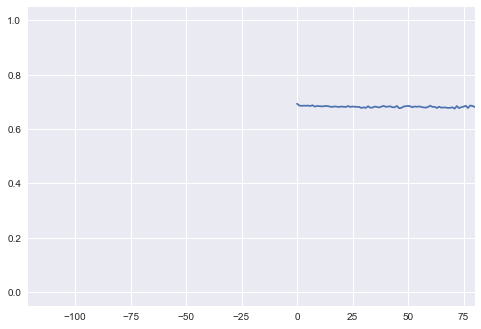

In [39]:
plt.plot(newtrain.groupby(['n_in_a_row_3600'])['is_listened'].mean())
plt.xlim(xmax = 80)

### Exponential moving average

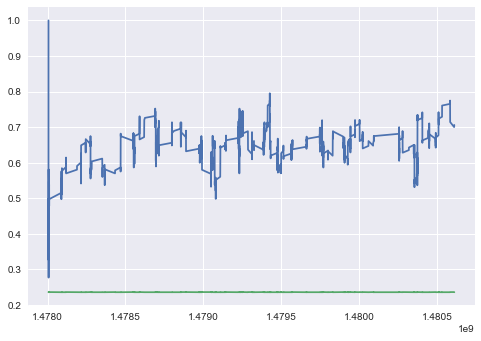

In [40]:
p = newtrain[newtrain['user_id'] == 150][['ts_listen', 'is_listened', 'avrg_listened_user_id']].sort_values(['ts_listen'])
plt.plot(p['ts_listen'], pd.ewma(p['is_listened'], span = 100), '-')
plt.plot(p['ts_listen'], p['avrg_listened_user_id'], '-')

In [41]:
def ewm(span = 1000):
    return lambda u: pd.ewma(newtrain[newtrain['user_id'] == u][['ts_listen', 'is_listened']].sort_values(['ts_listen'])['is_listened'], span = span)

In [ ]:
for s in [10, 100, 1000]:
    
    ewmseries = pd.Series()

    for i, u in enumerate(np.unique(newtest['user_id'])):
        if (i*10)%len(np.unique(newtest['user_id'])) == 0:
            print(str(s).rjust(6) + '   ' + str(np.round(i*100/len(np.unique(newtest['user_id'])),2)) + '%')
            
        local_ewmseries = ewm(span = s)(u)
        local_ewmseries = local_ewmseries.append(pd.Series([0], index = newtest.index[newtest['user_id'] == u]))
        local_ewmseries = local_ewmseries.shift(1).fillna(.5)
        ewmseries = ewmseries.append(local_ewmseries)
    
    ewmseries.name = 'ewmColumn_' + str(s)
    combined = combined.join(ewmseries, None, 'left', 'l')
    print()

## Average length of series

In [40]:
import itertools 

def get_mean_durations(bits):
    durations_ones = [sum(g) for b, g in itertools.groupby(bits) if b]
    durations_zeros = [sum(g) for b, g in itertools.groupby(1-bits) if b]
    
    if len(durations_ones) == 0:
        mean_durations_ones = 0
    else:
        mean_durations_ones = np.mean(durations_ones)
    
    if len(durations_zeros) == 0:
        mean_durations_zeros = 0
    else:
        mean_durations_zeros = np.mean(durations_zeros)  
    
    return mean_durations_ones, mean_durations_zeros

In [41]:
def survival_probability(bits):
    
    if len(bits) == 1:
        return np.nan, np.nan
    
    if len(np.unique(bits[:-1])) == 1: #bits is a constant series
        if len(np.unique(bits)) == 1:
            if np.unique(bits) == np.array([0]): #bits is a constant series, equal to 0
                return 1,np.nan

            else: #np.unique(bits) == np.array([1]): #bits is a constant series, equal to 1
                return np.nan,1

        else:
            if np.unique(bits[:-1]) == np.array([0]): #case [0,0,0,...,0,0,1]
                return (len(bits) - 2) / (len(bits) - 1), np.nan
            else: #np.unique(bits[:-1]) == np.array([1]): #case [1,1,1,...,1,1,0]
                return np.nan, (len(bits) - 2) / (len(bits) - 1)
    
    #Now, case where 'everything is fine': there are 0 and 1
    diff = bits[1:] - bits[:-1]
    mult = bits[:-1] * bits[1:]
    transitions_all = diff + 2*mult
    
    count_0 = list(transitions_all).count(0) #transition 0->0
    count_1 = list(transitions_all).count(1) #transition 0->1
    count_2 = list(transitions_all).count(2) #transition 1->1
    count_minus1 = list(transitions_all).count(-1) #transition 1->0
    
    survival_probability_0 = count_0 / (count_0 + count_1) #proba, given x_t = 0, of having x_t+1 = 0
    survival_probability_1 = count_2 / (count_2 + count_minus1) #proba, given x_t = 1, of having x_t+1 = 1
    return survival_probability_0, survival_probability_1

In [42]:
# survival = pd.DataFrame(columns=('user_id', 'svp_0', 'svp_1', 'md_1', 'md_0'))
survival = []
for user, group in train.sort_values('ts_listen').groupby(['user_id']):
    #the variable "group" is all the songs that the user listened to
    binary_list = group.sort_values('ts_listen')['is_listened'].values    
    survival += [np.append(user, np.ravel(np.array((survival_probability(binary_list), get_mean_durations(binary_list)))))]
    
survival = np.vstack(survival)

In [43]:
svdf = pd.DataFrame(survival)
svdf.columns = ['user_id', 'svp_0', 'svp_1', 'md_1', 'md_0']
combined = combined.join(svdf, 'user_id', 'left', 'l')

combined['svp_0'] /= combined['count_user_id'] > 5
combined['svp_1'] /= combined['count_user_id'] > 5
combined['md_0'] /= combined['count_user_id'] > 5
combined['md_1'] /= combined['count_user_id'] > 5
combined.replace([np.inf, -np.inf], np.nan, inplace=True)

combined['svp_0'].fillna(np.median(combined[~np.isnan(combined['svp_0'])]['svp_0']), inplace=True)
combined['svp_1'].fillna(np.median(combined[~np.isnan(combined['svp_1'])]['svp_1']), inplace=True)
combined['md_1'].fillna(np.median(combined[~np.isnan(combined['md_1'])]['md_1']), inplace=True)
combined['md_0'].fillna(np.median(combined[~np.isnan(combined['md_0'])]['md_0']), inplace=True)
combined.drop('user_idl', axis = 1, inplace = True)
combined

,genre_id,ts_listen,media_id,album_id,context_type,release_date,media_duration,listen_type,user_gender,artist_id,user_age,platform_name_0,platform_name_1,platform_name_2,platform_family_0,platform_family_1,platform_family_2,count_user_id,avrg_listened_user_id,count_user_id_listen_type,avrg_listened_user_id_listen_type,count_user_id_artist_id,count_user_id_artist_id_listen_type,count_user_id_media_id,count_user_id_media_id_listen_type,count_user_id_genre_id,avrg_listened_user_id_genre_id,count_user_id_genre_id_listen_type,avrg_listened_user_id_genre_id_listen_type,age_song,time_to_prev,n_in_a_row_30,n_in_a_row_60,n_in_a_row_180,n_in_a_row_300,n_in_a_row_600,n_in_a_row_1800,n_in_a_row_3600,n_in_a_row_43200,n_in_a_row_86400,n_listened_in_a_row_30,n_listened_in_a_row_60,n_listened_in_a_row_180,n_listened_in_a_row_300,n_listened_in_a_row_600,n_listened_in_a_row_1800,n_listened_in_a_row_3600,n_listened_in_a_row_43200,n_listened_in_a_row_86400,hour,avg_per_hour,user_id,svp_0,svp_1,md_1,md_0
0,25471,1480597215,222606,41774,12,1.088550e+09,223,0,0,55164,29,0,1,0,1,0,0,226,0.680000,142.0,0.695035,1.0,1.0,1.0,1.0,3.0,0.680000,3.0,0.680000,3.920472e+08,12.0,3.0,7.0,25.0,25.0,25.0,25.0,25.0,42.0,124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13,0.684049,9241.0,0.611111,0.810458,5.275862,2.517241
1,25571,1480544735,250467,43941,0,1.141085e+09,171,0,0,55830,30,0,0,1,0,1,0,40,0.564103,39.0,0.578947,1.0,1.0,1.0,1.0,1.0,0.564103,1.0,0.564103,3.394599e+08,194.0,0.0,0.0,0.0,8.0,8.0,9.0,9.0,9.0,9.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,22,0.681930,16547.0,0.588235,0.681818,2.875000,2.428571
2,16,1479563953,305197,48078,1,1.404083e+09,149,1,1,2704,29,0,0,1,0,1,0,302,0.986711,88.0,0.977011,1.0,1.0,1.0,1.0,1.0,0.986711,1.0,0.986711,7.548115e+07,33.0,0.0,2.0,3.0,3.0,3.0,3.0,14.0,14.0,79.0,0.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,13,0.684049,7665.0,0.000000,0.986532,59.600000,1.000000
3,7,1480152098,900502,71521,0,9.702684e+08,240,0,1,938,30,1,0,0,1,0,0,1075,0.587523,781.0,0.603846,2.0,1.0,1.0,1.0,75.0,0.648649,41.0,0.675000,5.098837e+08,6.0,1.0,1.0,2.0,40.0,40.0,101.0,101.0,202.0,286.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,0.684683,1580.0,0.722973,0.804762,5.088710,3.609756
4,7,1478368974,542335,71718,0,1.201738e+09,150,0,1,2939,24,1,0,0,1,0,0,998,0.933801,806.0,0.932919,8.0,8.0,8.0,8.0,194.0,0.943005,171.0,0.947059,2.766314e+08,26052.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,131.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,18,0.684091,1812.0,0.545455,0.967777,30.064516,2.200000
5,7,1478382544,542335,71718,0,1.201738e+09,150,0,1,2939,24,1,0,0,1,0,0,998,0.933801,806.0,0.932919,8.0,8.0,8.0,8.0,194.0,0.943005,171.0,0.947059,2.766449e+08,148.0,0.0,0.0,1.0,11.0,13.0,13.0,13.0,40.0,149.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21,0.683857,1812.0,0.545455,0.967777,30.064516,2.200000
6,7,1478338409,542335,71718,0,1.201738e+09,150,0,1,2939,24,1,0,0,1,0,0,998,0.933801,806.0,0.932919,8.0,8.0,8.0,8.0,194.0,0.943005,171.0,0.947059,2.766008e+08,148.0,0.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,113.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,9,0.684683,1812.0,0.545455,0.967777,30.064516,2.200000
7,7,1478353709,542335,71718,1,1.201738e+09,150,1,1,2939,29,0,1,0,1,0,0,184,0.765027,100.0,0.717172,1.0,1.0,1.0,1.0,39.0,0.868421,23.0,0.818182,2.766161e+08,312.0,0.0,0.0,0.0,0.0,7.0,7.0,7.0,7.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13,0.684049,10325.0,0.558140,0.864286,7.050000,2.263158
8,7,1479130924,542335,71718,0,1.201738e+09,150,0,1,2939,24,1,0,0,1,0,0,998,0.933801,806.0,0.932919,8.0,8.0,8.0,8.0,194.0,0.943005,171.0,0.947059,2.773933e+08,123.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13,0.684049,1812.0,0.545455,0.967777,30.064516,2.200000
9,7,1479214304,542335,71718,1,1.201738e+09,150,1,1,2939,28,0,1,0,0,0,1,3550,0.991265,2444.0,0.995088,2.0,2.0,1.0,1.0,657.0,0.996951,475.0,0.997890,2.774767e+08,331.0,0.0,0.0,0.0,0.0,39.0,39.0,39.0,39.0,143.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,12,0.684964,51.0,0.419355,0.994883,185.210526,1.722222


## LOAD DATA (if necessary)

In [44]:
combined.to_csv('temp_combined.csv', index=False)
target.to_csv('temp_target.csv', index=False)

In [45]:
combined = pd.read_csv('temp_combined.csv')
target = pd.read_csv('temp_target.csv', header = None)

<h1> IV. Modeling </h1>

## Separate the modified train and test sets

In [47]:
newtrain = combined[:len(target)]
newtest = combined[len(target):]

In [48]:
# On enleve ~ 5000 users... soit 22000 lignes

In [49]:
# target.drop(target.index[newtrain['count_user_id_listen_type'] < 5], axis = 0, inplace = True)
# newtrain.drop(newtrain.index[newtrain['count_user_id_listen_type'] < 5], axis = 0, inplace = True)

In [50]:
combined = newtrain.append(newtest)

## CENTER DATA

In [51]:
#efficace sinon ts_listen est tres important

for _ in combined.columns:
    if np.std(combined[_][:len(target)]) != 0:
        combined[_] = (combined[_] - np.mean(combined[_][:len(target)]))/np.std(combined[_][:len(target)])

In [52]:
newtrain = combined[:len(target)]
newtest = combined[len(target):]

## Remove elements with not enough values for flow and no flow

## A function to visualize the importance of the features

In [53]:
def importanceVisualisation(feature_importance, predictors, firstN = 40):
    
    plt.rcParams["figure.figsize"] = [40,10]
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.subplot(1, 2, 2)
    plt.bar(pos[-firstN:], feature_importance[sorted_idx][-firstN:], align='center')
    plt.xticks(pos[-firstN:], predictors[sorted_idx][-firstN:], rotation='vertical')
    plt.ylabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()

<h1> IV - 1. Gradient Boosting </h1>

In [54]:
from sklearn import ensemble
params = {'n_estimators': 200, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'huber', 'verbose':1}
gbr = ensemble.GradientBoostingRegressor(**params)

In [56]:
index = np.random.choice(target.index, len(target)//10)

In [73]:
# to_keep = newtrain.columns[[np.argsort(-gbr.feature_importances_)]][:26]
to_keep = ['n_in_a_row_60',
       'n_in_a_row_30', 'n_in_a_row_180', 'count_user_id_media_id',
       'n_in_a_row_600', 'md_1', 'svp_0', 'media_duration', 'md_0',
       'n_listened_in_a_row_60', 'context_type', 'count_user_id_artist_id',
       'svp_1', 'n_listened_in_a_row_30', 'n_in_a_row_1800',
       'count_user_id_artist_id_listen_type',
       'avrg_listened_user_id_listen_type', 'avrg_listened_user_id_genre_id']
newtrainlight, newtestlight = newtrain[to_keep], newtest[to_keep]

In [69]:
# gbr.fit(newtrainlight.ix[index], target.ix[index])
gbr.fit(newtrain, target)

      Iter       Train Loss   Remaining Time 
         1           0.1562          216.22m
         2           0.1543          216.33m
         3           0.1526          214.94m
         4           0.1508          214.01m
         5           0.1491          213.12m
         6           0.1474          212.11m
         7           0.1458          211.06m
         8           0.1442          210.07m
         9           0.1426          208.87m
        10           0.1410          207.83m
        20           0.1270          197.59m
        30           0.1154          186.82m
        40           0.1059          175.65m
        50           0.0978          164.56m
        60           0.0911          153.49m
        70           0.0856          142.44m
        80           0.0809          131.46m
        90           0.0770          120.52m
       100           0.0738          109.52m
       200           0.0625            0.00s


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='huber', max_depth=4,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=None,
             subsample=1.0, verbose=1, warm_start=False)

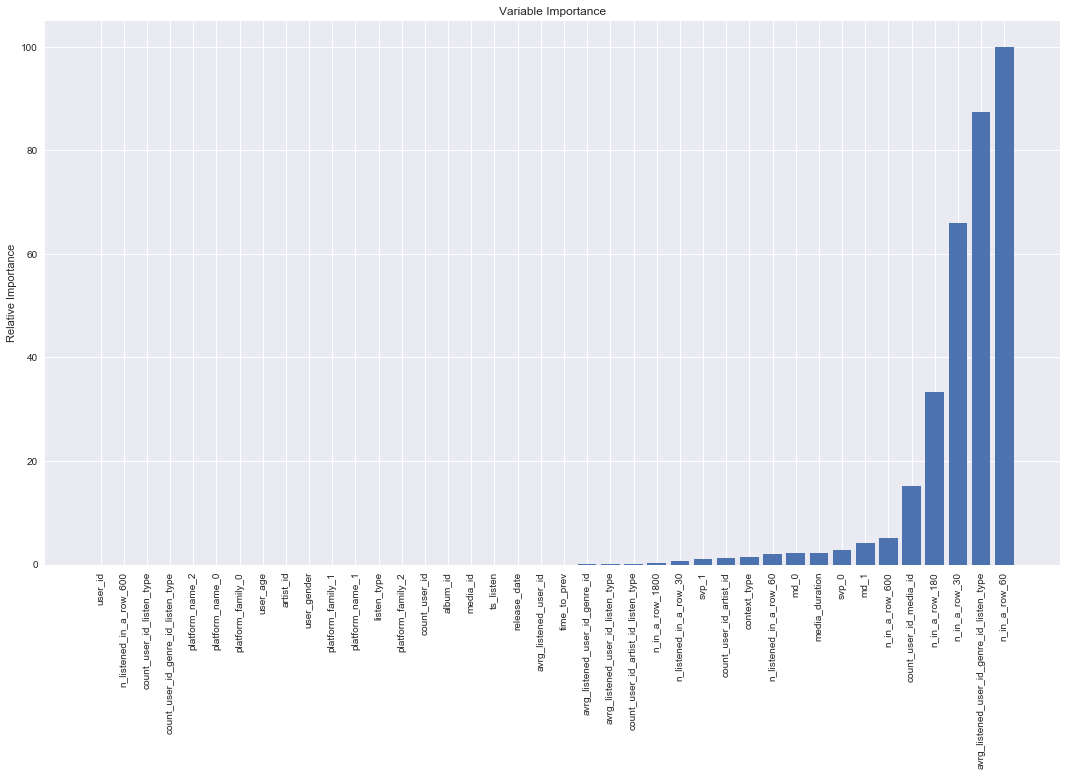

In [70]:
importanceVisualisation(gbr.feature_importances_, newtrain.columns)

In [71]:
from sklearn.metrics import roc_auc_score
roc_auc_score(target, gbr.predict(newtrain))

0.88358921458578932

In [72]:
newtrain.columns[list(map(lambda x: x[0], sorted(list(enumerate(gbr.feature_importances_)), key=lambda x: x[1], reverse = True)))]

Index(['n_in_a_row_60', 'avrg_listened_user_id_genre_id_listen_type',
       'n_in_a_row_30', 'n_in_a_row_180', 'count_user_id_media_id',
       'n_in_a_row_600', 'md_1', 'svp_0', 'media_duration', 'md_0',
       'n_listened_in_a_row_60', 'context_type', 'count_user_id_artist_id',
       'svp_1', 'n_listened_in_a_row_30', 'n_in_a_row_1800',
       'count_user_id_artist_id_listen_type',
       'avrg_listened_user_id_listen_type', 'avrg_listened_user_id_genre_id',
       'time_to_prev', 'genre_id', 'ts_listen', 'media_id', 'album_id',
       'release_date', 'listen_type', 'user_gender', 'artist_id', 'user_age',
       'platform_name_0', 'platform_name_1', 'platform_name_2',
       'platform_family_0', 'platform_family_1', 'platform_family_2',
       'count_user_id', 'avrg_listened_user_id', 'count_user_id_listen_type',
       'count_user_id_media_id_listen_type', 'count_user_id_genre_id',
       'count_user_id_genre_id_listen_type', 'age_song', 'n_in_a_row_300',
       'n_in_a_row_3600',

# Neural networks

In [74]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape, Embedding, Lambda
from keras.layers import Conv2D, MaxPooling2D, LSTM, Bidirectional, Input, Conv1D, concatenate, MaxPooling1D, GlobalMaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras import backend as K

In [75]:
def unison_shuffled_copies(a, b, useseed = False):
    assert len(a) == len(b)
    if useseed:
        np.random.seed(seed=23)
    p = np.random.permutation(len(a))
    return a[p], b[p], p

In [76]:
ntShuf, tShuf, _ = unison_shuffled_copies(np.array(newtrainlight), np.array(target))

In [77]:
batch_size = 32
num_classes = 2
epochs = 2
len_train = int(.98*len(target))

In [78]:
# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = (ntShuf[:len_train], to_categorical(tShuf[:len_train], num_classes = num_classes)), (ntShuf[len_train:], to_categorical(tShuf[len_train:], num_classes = num_classes))
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (7406529, 18)
7406529 train samples
151154 test samples


In [87]:
neural = Sequential()

### CHECK THAT THE PARAMETERS ARE CORRECTLY TUNED ###

dropout = .9

neural.add(Dense(x_train.shape[1], input_shape = x_train[0].shape))
neural.add(BatchNormalization(axis = -1))
neural.add(Activation('relu'))
neural.add(Dropout(dropout))
neural.add(Dense(x_train.shape[1]))
neural.add(BatchNormalization(axis = -1))
neural.add(Activation('relu'))
neural.add(Dropout(dropout))
neural.add(Dense(16))
neural.add(BatchNormalization(axis = -1))
neural.add(Activation('relu'))
neural.add(Dropout(dropout))
neural.add(Dense(2))
neural.add(BatchNormalization(axis = -1))
neural.add(Activation('softmax'))


opt = keras.optimizers.rmsprop(lr=0.01, decay=1e-6)

In [88]:
from keras.callbacks import TensorBoard
# tensorboard --logdir=/tmp/charNN
# localhost:6006

checkpoints = keras.callbacks.ModelCheckpoint('./models/{epoch:02d}-{val_acc:.2f}.model', monitor='val_acc', save_best_only=True, save_weights_only=False, mode='auto', period=1)

# Let's train the model using RMSprop
neural.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

hist = neural.fit(x_train, y_train, epochs = epochs, validation_data = (x_test, y_test), batch_size = batch_size, callbacks=[TensorBoard(log_dir='./tensorboard/'), checkpoints])

Train on 7406529 samples, validate on 151154 samples
Epoch 1/2
7406529/7406529 [==============================] - 462s - loss: 0.5986 - acc: 0.7043 - val_loss: 0.5770 - val_acc: 0.6942
Epoch 2/2
7406529/7406529 [==============================] - 459s - loss: 0.5975 - acc: 0.7051 - val_loss: 0.5792 - val_acc: 0.6946


In [89]:
a = neural.predict_proba(x_test)

148416/151154 [============================>.] - ETA: 0s

In [90]:
from sklearn.metrics import roc_auc_score
roc_auc_score(tShuf[len_train:], a[:, 1])

0.86704356485236722

In [91]:
newtrainlight.columns

Index(['n_in_a_row_60', 'n_in_a_row_30', 'n_in_a_row_180',
       'count_user_id_media_id', 'n_in_a_row_600', 'md_1', 'svp_0',
       'media_duration', 'md_0', 'n_listened_in_a_row_60', 'context_type',
       'count_user_id_artist_id', 'svp_1', 'n_listened_in_a_row_30',
       'n_in_a_row_1800', 'count_user_id_artist_id_listen_type',
       'avrg_listened_user_id_listen_type', 'avrg_listened_user_id_genre_id'],
      dtype='object')

<h1> IV - 2. XGBoost </h1>

In [6]:
from sklearn.model_selection import cross_val_predict

def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50, plot = False):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=target.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], target, verbose_eval = True, eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(target.values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(target, dtrain_predprob))
    predicted_cv = cross_val_predict(alg, dtrain, target, cv = 5, n_jobs = -1)
    print('AUC Score (CV):',metrics.roc_auc_score(target, predicted_cv))
    
    if plot:
        importanceVisualisation(pd.Series(alg.booster().get_fscore()), predictors)

In [ ]:
predictors = newtrain.columns

## FIRST MODEL

In [ ]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
#  nthread=-1,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, newtrain, predictors)

## GRID SEARCH ON XGBOOST TO FIND THE BEST PARAMETERS (VERY LONG)

## Grid search on 'max_depth' and 'min_child_weight'

In [ ]:
# param_test1 = {
#  'max_depth':np.array(range(3,10,2)),
#  'min_child_weight':np.array(range(1,6,2))
# }
# gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
#  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
#  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
#  param_grid = param_test1, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
# gsearch1.fit(newtrain[predictors],target)
# gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

## Finer grid search on 'max_depth' and 'min_child_weight'

In [ ]:
# param_test2 = {
#  'max_depth':[2,3,4],
#  'min_child_weight':[2,3,4]
# }
# gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
#  min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
#  objective= 'binary:logistic', nthread=-1, scale_pos_weight=1,seed=27), 
#  param_grid = param_test2, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
# gsearch2.fit(newtrain[predictors],target)
# gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

## Grid search on 'gamma'

In [ ]:
# param_test3 = {
#  'gamma':[i/10.0 for i in range(0,5)]
# }
# gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
#  min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
#  objective= 'binary:logistic', nthread=-1, scale_pos_weight=1,seed=27), 
#  param_grid = param_test3, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
# gsearch3.fit(newtrain[predictors],target)
# gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

## Grid search on 'subsample' and 'colsample_bytree'

In [ ]:
# param_test4 = { 
#  'subsample':[i/10.0 for i in range(6,11)],
#  'colsample_bytree':[i/10.0 for i in range(6,11)]
# }
# gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
#  min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
#  objective= 'binary:logistic', nthread=-1, scale_pos_weight=1,seed=27), 
#  param_grid = param_test4, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
# gsearch4.fit(newtrain[predictors],target)
# gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

## Grid search on 'reg_alpha'

In [ ]:
# param_test6 = {
#  'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
# }
# gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
#  min_child_weight=4, gamma=0, subsample=1.0, colsample_bytree=0.6,
#  objective= 'binary:logistic', nthread=-1, scale_pos_weight=1,seed=27), 
#  param_grid = param_test6, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
# gsearch6.fit(newtrain,target)
# gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

In [ ]:
# param_test7 = {
#  'reg_alpha':[0.5,1,2,5,10]
# }
# gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
#  min_child_weight=4, gamma=0, subsample=1.0, colsample_bytree=0.6,
#  objective= 'binary:logistic', nthread=-1, scale_pos_weight=1,seed=27), 
#  param_grid = param_test7, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
# gsearch7.fit(newtrain,target)
# gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

## Grid search on 'learning_rate' and 'n_estimators'

In [209]:
param_test8 = {
 'learning_rate': [0.1,0.01,0.001],
 'n_estimators': [1000,5000,10000]
}
gsearch8 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=0, gamma=0.3, subsample=0.9, reg_alpha = 0.2, colsample_bytree=0.9,
 objective= 'binary:logistic', nthread=-1, scale_pos_weight=1,seed=40), 
 param_grid = param_test8, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch8.fit(newtrain,target)
gsearch8.grid_scores_, gsearch8.best_params_, gsearch8.best_score_

([mean: 0.80282, std: 0.00984, params: {'n_estimators': 1000, 'learning_rate': 0.1},
  mean: 0.80199, std: 0.01003, params: {'n_estimators': 5000, 'learning_rate': 0.1},
  mean: 0.80175, std: 0.01035, params: {'n_estimators': 10000, 'learning_rate': 0.1},
  mean: 0.81651, std: 0.00992, params: {'n_estimators': 1000, 'learning_rate': 0.01},
  mean: 0.80989, std: 0.00944, params: {'n_estimators': 5000, 'learning_rate': 0.01},
  mean: 0.80797, std: 0.00966, params: {'n_estimators': 10000, 'learning_rate': 0.01},
  mean: 0.81178, std: 0.00623, params: {'n_estimators': 1000, 'learning_rate': 0.001},
  mean: 0.81843, std: 0.00840, params: {'n_estimators': 5000, 'learning_rate': 0.001},
  mean: 0.81649, std: 0.00936, params: {'n_estimators': 10000, 'learning_rate': 0.001}],
 {'learning_rate': 0.001, 'n_estimators': 5000},
 0.8184288230374144)

## FINAL MODEL

In [28]:
# XgbParams = {'learning_rate': 0.001, 'n_estimators':10000, 'max_depth':6, 'min_child_weight':3, 'gamma':0,
#             'subsample':0.9, 'colsample_bytree':0.6, 'reg_alpha':1e-5, 'objective': 'binary:logistic',
#              'nthread':-1, 'scale_pos_weight':1}

XgbParams = {'learning_rate': 0.001, 'n_estimators':1000, 'max_depth':5, 'min_child_weight':0, 'gamma':0.3,
            'subsample':0.9, 'colsample_bytree':0.9, 'reg_alpha':0.2, 'objective': 'binary:logistic',
             'nthread':-1, 'scale_pos_weight':1}

# XgbParams = {'learning_rate': 0.01, 'n_estimators':1000, 'max_depth':4, 'min_child_weight':4, 'gamma':0,
#             'subsample':1, 'colsample_bytree':0.6, 'reg_alpha':1, 'objective': 'binary:logistic',
#              'nthread':-1, 'scale_pos_weight':1}

In [ ]:
xgb3 = XGBClassifier(**XgbParams, seed=27)
modelfit(xgb3, newtrain, predictors, plot = False)

In [216]:
xgb3 = XGBClassifier(**XgbParams, seed=40)
modelfit(xgb3, newtrain, predictors, plot = False)


Model Report
Accuracy : 0.7944
AUC Score (Train): 0.885769
AUC Score (CV): 0.721147862905


<h1> VI. Final Prediction </h1> (We take the best xgboost model here)

In [68]:
gbrpred = gbr.predict(newtestlight)
df_output = pd.DataFrame()
df_output['sample_id'] = IDtest
df_output['is_listened'] = gbrpred
df_output[['sample_id','is_listened']].to_csv('./predictions/GBRoutput.csv', sep = ",", index=False)

In [92]:
nnpred = neural.predict_proba(np.array(newtestlight))[:, 1]
df_output = pd.DataFrame()
df_output['sample_id'] = IDtest
df_output['is_listened'] = nnpred
df_output[['sample_id','is_listened']].to_csv('./predictions/NNoutput.csv', sep = ",", index=False)

19168/19918 [===========================>..] - ETA: 0s